In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn


In [2]:
class DNN(nn.Module):
    def __init__(self, probe_size, latent_size):
        super(DNN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(probe_size, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_size)
        )

    def forward(self, x):
        return self.network(x)

# Example usage:
# Create a model with an output size of 32
output_dim = 32
model = DNN(probe_size=7,latent_size=26)

# Test with a random input of 7 floats
dummy_input = torch.randn(1, 7)
output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(model)

Input shape: torch.Size([1, 7])
Output shape: torch.Size([1, 26])
DNN(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=26, bias=True)
  )
)


In [3]:
probe_data = np.random.rand(7,501)
latent_features = np.load('latent_features501.npy')
print(latent_features.shape)

(501, 26)


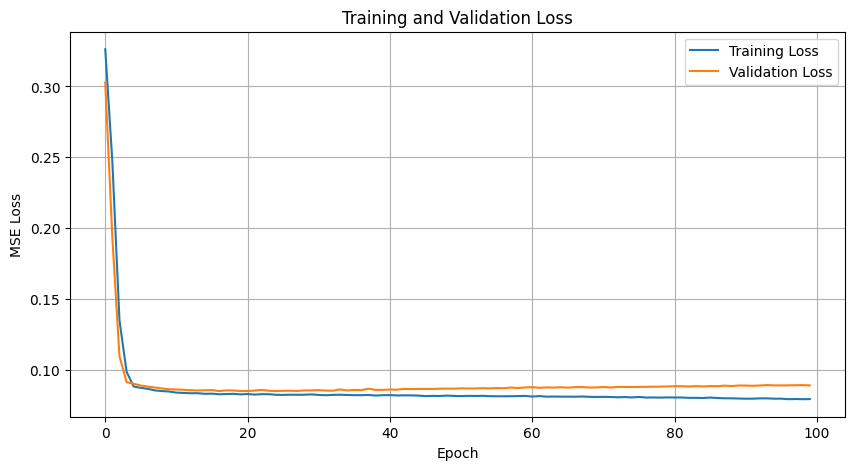

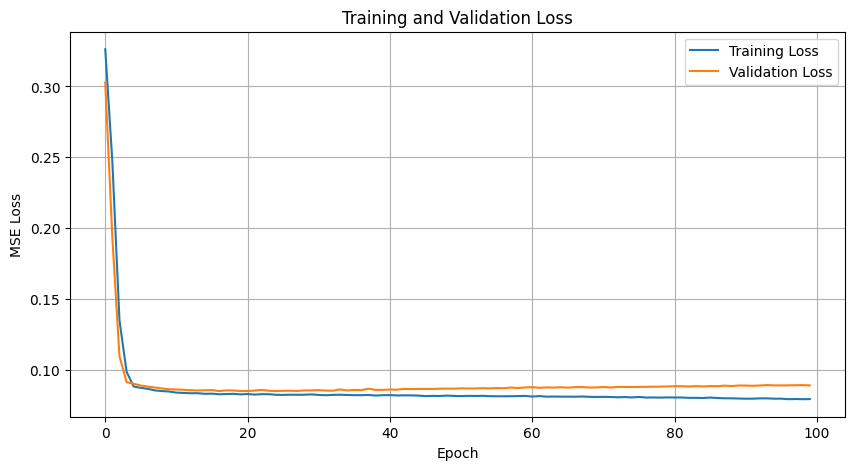

Epoch [100/100], Train Loss: 0.0796, Val Loss: 0.0892


In [12]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from IPython.display import clear_output

def plot_training_curves(train_elbo, train_log_p, train_kl, val_elbo, val_log_p, val_kl):
    clear_output(wait=True)
    
    # 1. ELBO
    plt.figure(figsize=(10, 5))
    plt.plot(train_elbo, label='Train ELBO', color='blue')
    plt.plot(val_elbo, label='Val ELBO', color='orange')
    plt.title('ELBO')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO')
    plt.legend()
    plt.grid(True)
    plt.savefig('elbo.png')
    plt.savefig('elbo.pdf')
    plt.show()

    # 2. Log Likelihood (log p(x|z))
    plt.figure(figsize=(10, 5))
    plt.plot(train_log_p, label='Train Log(p)', color='green')
    plt.plot(val_log_p, label='Val Log(p)', color='red')
    plt.title('Log Likelihood')
    plt.xlabel('Epoch')
    plt.ylabel('Log(p)')
    plt.legend()
    plt.grid(True)
    plt.savefig('log_likelihood.png')
    plt.savefig('log_likelihood.pdf')
    plt.show()

    # 3. KL Divergence
    plt.figure(figsize=(10, 5))
    plt.plot(train_kl, label='Train KL', color='purple')
    plt.plot(val_kl, label='Val KL', color='brown')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('KL')
    plt.legend()
    plt.grid(True)
    plt.savefig('kl_divergence.png')
    plt.savefig('kl_divergence.pdf')
    plt.show()

# 1. Prepare Data
# Transpose to (N_samples, N_features) because PyTorch expects (batch, features)
# probe_data is (7, 501) -> (501, 7)
# latent_features is (26, 501) -> (501, 26)
X = torch.tensor(probe_data.T, dtype=torch.float32) 
y = torch.tensor(latent_features.T, dtype=torch.float32)

# Create Dataset
dataset = TensorDataset(X, y)

# Split into Train (80%) and Validation (20%)
split = 0.8
train_size = int(split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 2. Initialize Model
output_dim = 26 # Based on latent_features shape (26 features)
model = DNN(probe_size=7, latent_size=output_dim)

# 3. Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
num_epochs = 100

# Lists to store metrics
train_elbos, train_log_ps, train_kls = [], [], []
val_elbos, val_log_ps, val_kls = [], [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_elbo, epoch_log_p, epoch_kl = 0.0, 0.0, 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        
        # For a standard DNN (deterministic), we can interpret:
        # Log Likelihood ~ -MSE (assuming Gaussian with fixed variance)
        # KL Divergence = 0 (no latent stochasticity)
        # ELBO = Log Likelihood - KL
        
        mse_loss = criterion(predictions, batch_y)
        
        # Metrics
        log_p = -mse_loss # Approximation
        kl = torch.tensor(0.0)
        elbo = log_p - kl
        
        loss = -elbo # Minimize negative ELBO (Maximize ELBO)
        # Note: Since kl=0, this is equivalent to minimizing MSE
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_elbo += elbo.item()
        epoch_log_p += log_p.item()
        epoch_kl += kl.item()
    
    # Average over batches
    train_elbos.append(epoch_elbo / len(train_loader))
    train_log_ps.append(epoch_log_p / len(train_loader))
    train_kls.append(epoch_kl / len(train_loader))

    # Validation Phase
    model.eval()
    val_epoch_elbo, val_epoch_log_p, val_epoch_kl = 0.0, 0.0, 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            mse_loss = criterion(predictions, batch_y)
            
            log_p = -mse_loss
            kl = torch.tensor(0.0)
            elbo = log_p - kl
            
            val_epoch_elbo += elbo.item()
            val_epoch_log_p += log_p.item()
            val_epoch_kl += kl.item()
    
    val_elbos.append(val_epoch_elbo / len(val_loader))
    val_log_ps.append(val_epoch_log_p / len(val_loader))
    val_kls.append(val_epoch_kl / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        plot_training_curves(train_elbos, train_log_ps, train_kls, 
                             val_elbos, val_log_ps, val_kls)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train ELBO: {train_elbos[-1]:.4f}, Val ELBO: {val_elbos[-1]:.4f}')